# 1-Dimensional Peridynamic code for a single bar with displacement boundary conditions at either end

Silling, S. A., & Askari, E. (2005). *A meshfree method based on the peridynamic model of solid mechanics*. *Computers & Structures, 83*(17-18), 1526-1535. https://doi.org/10.1016/j.compstruc.2004.11.026

1DPDpy: https://github.com/johntfoster/1DPDpy

## Setup

In this section, we will import the python libraries:

- **NumPy**: This library is fundamental for numerical computations in Python. It provides support for arrays, matrices, and many mathematical functions that operate on these data structures.
- **Matplotlib**: A plotting library for creating static, animated, and interactive visualizations in Python. It's particularly useful for generating plots, histograms, and other types of charts.
- **Pandas**: A python library used for working with data sets. It has functions for analyzing, cleaning, exploring, and manipulating data.
- **Seaborn**: This python library helps users visualize data through statistical graphics.
- **KDTree**: This python package can construct, modify and search kd-trees. A KD Tree is a space-partitioning data structure that organizes points in a k-dimensional space. It is particularly effective for multidimensional search operations such as range searches and nearest-neighbor searches. 

In [2]:
import numpy as np  
import matplotlib.pyplot as plt 
from matplotlib.animation import FuncAnimation, PillowWriter # For animation
import pandas as pd  
import seaborn as sns
from scipy.spatial import KDTree

## Parameters

### Consistency of Units in Calculations

To avoid errors in our calculations, we will adhere to a consistent set of units for the following physical quanities:

- Length/Distance: millimeters (mm)
- Mass: kilograms (kg)
- Time: microseconds (μs)

In [3]:
rho = 8e-6 #material density
Young_modulus = 19578.55 
nu = 0.3 #Poisson's Ratio
K = Young_modulus/(3.0*(1-2.0*nu)) 
horizon = 1.6
s0 = 0.02 # critical stretch 
total_time = 15 
del_T = .1 
time_steps = int(total_time/del_T)
bar_length = 15
number_of_elements = 7
nx = number_of_elements
ny = 1
delta_x = bar_length / number_of_elements
# specify nodes along the bar in 1 dimension
nodes = np.linspace(-bar_length/2.0, bar_length/2.0, number_of_elements)
# find the coordinates of the nodes along the length of the bar
nodes_coords = np.column_stack((nodes, np.ones_like(nodes))) 
# define horizon 
horizon = delta_x * 3.014
vol = 1 #assumption

In [4]:
# Create an array of IDs for each node
ids = np.arange(len(nodes))

# Combine the IDs with the node coordinates, stacking them column-wise
nodes_with_ids = np.column_stack((ids, nodes_coords))

nodes_with_ids

array([[ 0. , -7.5,  1. ],
       [ 1. , -5. ,  1. ],
       [ 2. , -2.5,  1. ],
       [ 3. ,  0. ,  1. ],
       [ 4. ,  2.5,  1. ],
       [ 5. ,  5. ,  1. ],
       [ 6. ,  7.5,  1. ]])

## Boundary Conditions

<img src="fig5.png" alt="Velocity applied to plate horizontal edges" width="600">

In [5]:
"""
    Boundary conditions
"""
u_applied_05 = np.linspace(2e-2,2e-2,time_steps//3)
u_applied_510 = np.linspace(-2e-2,-2e-2,time_steps//3)
u_applied_1015 = np.linspace(0,0,time_steps//3)
u_applied = np.concatenate((u_applied_05, u_applied_510, u_applied_1015))

## Displacement calculations

In [6]:
# Initialize an array to store displacement vectors for each node at every time step
u_vector_solution = np.zeros((time_steps, nx, ny))
print("Shape for u_vector_solution: ", u_vector_solution.shape)

# Initialize an array to store the current displacement vector for each node
u_vector_at_current_time_step = np.zeros((nx, ny))
print("Shape for u_vector_at_current_time_step: ", u_vector_at_current_time_step.shape)

# Initialize the displacement vector at the future time step
u_vector_at_future_time_step = np.zeros((nx, ny))

# Initialize the displacement vector at the previous time step
u_vector_at_previous_time_step = np.zeros((nx, ny))

# Loop over each time step to calculate the displacement of nodes
for n in range(0, time_steps):

    # Calculate the elapsed time for the current time step
    time_elapsed = n * del_T
    
    # Define the start and end positions for the nodes based on the horizon
    start_position = -bar_length/2.0
    end_position = bar_length/2.0

    # Initialize the node values for the current time step
    node_values = np.zeros((nx, ny))
    
    # Assign boundary conditions to nodes at the start and end positions within the horizon
    for i in range(len(nodes)):
        if abs(nodes[i] - start_position) <= horizon or abs(nodes[i] - end_position) <= horizon:
            node_values[i, 0] = u_applied[n] # Apply the boundary condition
    
    # Loop over all nodes in the grid
    for x in range(nx):
        for y in range(ny):

            # Initialize the sum term 
            sum_term = 0
            
            # xi represents the value of the node at the current location
            xi = node_values[x][y]
            xi_index = int(nodes_with_ids[x][0])
            
            # Get the coordinates of the node at the current location (xi)
            xi_locx = nodes_coords[x][0]
            xi_locy = nodes_coords[x][1]

            """
            We got the values for the ith nodes. Now get the neighboring nodes (xp).
            """

            # Find the neighboring nodes for xi
            node_index = int(nodes_with_ids[x][0])
            tree= KDTree(nodes_coords)
            neighbor_ids = tree.query_ball_point(nodes_coords[node_index], horizon)

            # Loop through each neighboring node
            for p in range(len(neighbor_ids)):
                # Get the coordinates of the neighboring node (xp)
                xp_locx = int(nodes_coords[p][0])
                xp_locy = int(nodes_coords[p][1])
                xp_index = int(nodes_with_ids[p][0])
                xp = node_values[xp_index]
                xp_index = int(nodes_with_ids[p][0])

                # Skip the current node itself (xi)
                if xp_index == xi_index:
                    continue

                # Calculate the distance (ksi) between the xi and xp
                ksi = np.sqrt((xp_locx-xi_locx)**2 + (xp_locy-xi_locy)**2)

                # Calculate the difference in displacement (eta) between xi and xp
                eta = xp - xi

                # Calculate the material constant c based on bulk modulus K and horizon distance    
                c = (18*K)/(np.pi * horizon**4)

                # Calculate the stretch s
                s = ((np.abs(ksi+eta)) - np.abs(ksi))/np.abs(ksi)

                # Determine the damage factor mu based on a threshold s0
                if s > s0:
                    mu = 0  # Set mu to 0 if stretch exceeds threshold, representing damage
                else:
                    mu = 1  # Set mu to 1 if no damage occurs
                
                # calculate the summation term in the equation of motion
                sum_term = sum_term + ((((ksi+eta)/np.abs(ksi+eta)) * c * s * mu)*vol) + 9.8e-9 #(body force = 9.8 m/s^2)

                # calculate the acceleration
                acceleration = sum_term/rho

        # using explicit central difference formula
        u_vector_at_future_time_step[x,y] = (acceleration*del_T**2) + (2*u_vector_at_current_time_step[x,y]) - u_vector_at_previous_time_step[x, y]

        # update the array holding the vector solutions
        u_vector_solution[n, x, y] = u_vector_at_current_time_step[x, y]

    # update the arrays for the next iteration
    u_vector_at_previous_time_step = u_vector_at_current_time_step.copy()
    u_vector_at_current_time_step = u_vector_at_future_time_step.copy()

Shape for u_vector_solution:  (150, 7, 1)
Shape for u_vector_at_current_time_step:  (7, 1)


C:\Users\st35345\AppData\Local\Temp/ipykernel_11620/298607520.py:95: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_vector_at_future_time_step[x,y] = (acceleration*del_T**2) + (2*u_vector_at_current_time_step[x,y]) - u_vector_at_previous_time_step[x, y]


## Result Output

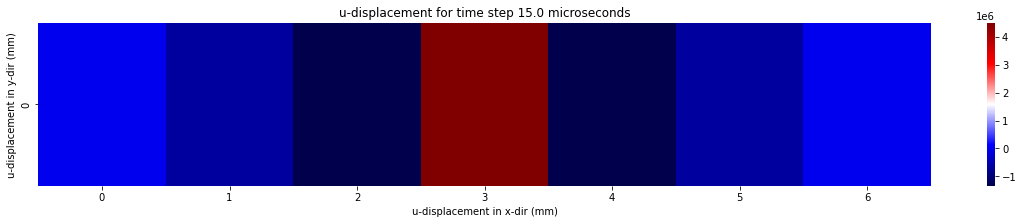

In [8]:
# set the figure size
fig, ax = plt.subplots(figsize=(20, 3))

# Find the min and max values 
vmin, vmax = np.min(u_vector_solution), np.max(u_vector_solution)

# Initialize with the first timestep
heatmap = sns.heatmap(u_vector_solution[0, :, :].reshape(1, -1), cmap='seismic', ax=ax, vmin=vmin, vmax=vmax)
plt.title('u-displacement vs time')
plt.xlabel('u-displacement in x-dir (mm)')
plt.ylabel('u-displacement in y-dir (mm)')

# update the frames
def update(frame):
    ax.clear()
    heatmap = sns.heatmap(u_vector_solution[frame, :, :].reshape(1, -1), cmap='seismic', ax=ax, vmin=vmin, vmax=vmax, cbar=False)
    ax.set_title(f'u-displacement for time step {(frame + 1)/10} microseconds')
    ax.set_xlabel('u-displacement in x-dir (mm)')
    ax.set_ylabel('u-displacement in y-dir (mm)')

# create the animation
anim = FuncAnimation(fig, update, frames=u_vector_solution.shape[0], interval=200)

# store the animation in .gif format
anim.save('animation1dbar.gif', writer=PillowWriter(fps=5))

plt.show()